In [48]:
import pandas as pd
import matplotlib.pyplot as plt

### Read CSV file(s)

In [49]:
air_df = pd.read_csv("data/aqi.csv")
weather_df = pd.read_csv("data/weather.csv")

In [50]:
air_df = air_df.rename(columns={"Unnamed: 0": "time"})
air_df.head()

,time,co,no2,o3,so2,pm2_5,pm10
0,2020-12-01T00:00:00,934.60,39.41,36.84,36.72,101.75,111.81
1,2020-12-01T01:00:00,1121.52,45.93,29.33,39.10,106.35,117.68
2,2020-12-01T02:00:00,1148.22,45.93,28.61,40.05,107.24,119.15
3,2020-12-01T03:00:00,1041.41,40.10,36.48,38.62,104.99,116.65
4,2020-12-01T04:00:00,921.25,34.27,49.35,35.76,100.41,111.00


In [51]:
weather_df = weather_df.rename(columns={"Unnamed: 0": "time"})
weather_df.head()

,time,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m
0,2020-12-01T00:00:00,16.9,61,9.5,0.0,1022.1,76,10.6,28
1,2020-12-01T01:00:00,17.4,59,9.3,0.0,1022.9,99,12.1,27
2,2020-12-01T02:00:00,17.8,58,9.5,0.0,1023.9,62,12.9,23
3,2020-12-01T03:00:00,18.7,56,9.9,0.0,1023.7,100,12.7,15
4,2020-12-01T04:00:00,19.4,55,10.3,0.0,1022.8,100,12.6,13


Set datetime types

In [52]:
weather_df['time'] = weather_df['time'].astype('datetime64[s]')
air_df['time'] = air_df['time'].astype('datetime64[s]')

In [53]:
weather_df.head()

,time,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m
0,2020-12-01 00:00:00,16.9,61,9.5,0.0,1022.1,76,10.6,28
1,2020-12-01 01:00:00,17.4,59,9.3,0.0,1022.9,99,12.1,27
2,2020-12-01 02:00:00,17.8,58,9.5,0.0,1023.9,62,12.9,23
3,2020-12-01 03:00:00,18.7,56,9.9,0.0,1023.7,100,12.7,15
4,2020-12-01 04:00:00,19.4,55,10.3,0.0,1022.8,100,12.6,13


Check null values (Later on interpolation may be needed)

In [54]:
print(air_df.isnull().values.any())
print(weather_df.isnull().values.any())

True
False


In [55]:
print((air_df.select_dtypes(include='number').isna()).sum())

co       480
no2      480
o3       480
so2      480
pm2_5    480
pm10     480
dtype: int64


Check negative values (Attributes only)

In [56]:
air_df_attr = air_df.iloc[:,1:]
weather_df_attr = weather_df.iloc[:,1:]


In [57]:
print((air_df_attr.values < 0).any())
print((weather_df_attr.values < 0).any())

True
True


In [58]:
print((air_df.select_dtypes(include='number') < 0).sum())

co       0
no2      2
o3       1
so2      0
pm2_5    0
pm10     1
dtype: int64


However for weather dataframe, only negative values are observed in dewpoint_2m column, measured in degrees Celsius (which can have values smaller than 0)

In [59]:
print((weather_df.select_dtypes(include='number') < 0).sum())

temperature_2m            0
relative_humidity_2m      0
dew_point_2m            180
precipitation             0
surface_pressure          0
cloud_cover               0
wind_speed_10m            0
wind_direction_10m        0
dtype: int64


Hence, we only remove negative values from air data

In [60]:
removed_neg_air = air_df.loc[air_df_attr[air_df_attr >= 0].dropna().index]

print(1 - removed_neg_air.shape[0]/air_df_attr.shape[0])

0.013802937401967807


1.38% of rows containing negative values for air data.

In [61]:
air_df = removed_neg_air

In [62]:
print((air_df.iloc[:,1:-1].values < 0).sum())

0


### Check missing timestamps

Set time as index

In [63]:
weather_df.set_index(weather_df.columns[0], inplace=True)
air_df.set_index(air_df.columns[0], inplace=True)

Match timestamps for air data and weather data

In [64]:
print(air_df.index.min(), air_df.index.max())
print(weather_df.index.min(), weather_df.index.max())

2020-12-01 00:00:00 2024-12-01 00:00:00
2020-12-01 00:00:00 2024-12-01 00:00:00


In [65]:
starting_timestamp = max(air_df.index.min(), weather_df.index.min())
ending_timestamp = min(air_df.index.max(), weather_df.index.max())

air_df = air_df[starting_timestamp:ending_timestamp]
weather_df = weather_df[starting_timestamp:ending_timestamp]

The total number of timestamps with missing and invalid data (Only air data)

Number of consecutive missing/invalid groups of entries: 20


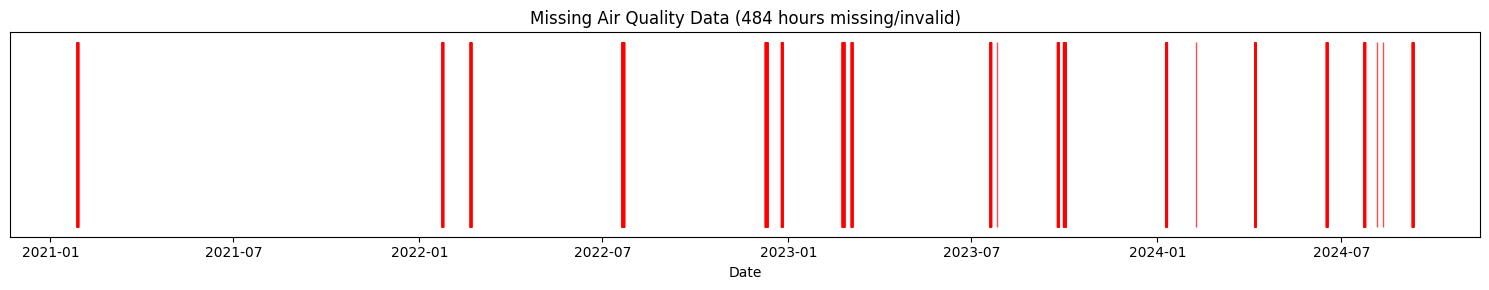

In [66]:
missing_hours = pd.date_range(start=air_df.index.min(), end=air_df.index.max(), freq='h').difference(air_df.index)

if len(missing_hours) > 0:
    num_groups = (pd.Series(missing_hours).diff() > pd.Timedelta('1h')).sum() + 1
else:
    num_groups = 0

print(f"Number of consecutive missing/invalid groups of entries: {num_groups}")

plt.figure(figsize= (15, 3))

plt.vlines(x=missing_hours, ymin=0, ymax=1, colors='red', linewidth=1, alpha=0.7)

plt.title(f"Missing Air Quality Data ({len(missing_hours)} hours missing/invalid)")
plt.xlabel("Date")
plt.yticks([])
plt.tight_layout()
plt.show()

### Interpolation (Only for air data)

In [67]:
start_date = air_df.index.min()
end_date = air_df.index.max()
full_range = pd.date_range(start=start_date, end=end_date, freq="h", name="time")

In [68]:
interpolated_air_df = aligned_air_df.interpolate(method="time", axis=0, limit_direction="both")

In [69]:
print(interpolated_air_df.isna().any())

co       False
no2      False
o3       False
so2      False
pm2_5    False
pm10     False
dtype: bool


Save dataframes

In [70]:
air_df.sort_index().to_csv("data/processed/cleaned/cleaned_air.csv")
weather_df.sort_index().to_csv("data/processed/cleaned/cleaned_weather.csv")
interpolated_air_df.sort_index().to_csv("data/processed/interpolated/interpolated_air.csv")